<a href="https://colab.research.google.com/github/EdoardoMorucci/Plant-Leaves-Search-Engine---MIRCV/blob/main/retrieval_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
! pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=86300f7d8c1ea3e6aebbd3ad2e6899e487417fcff6bcfb9f490a306b09c208d6
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [4]:
%cd "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/jupyter-notebooks"

/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/jupyter-notebooks


In [5]:
%run vpt_index.ipynb

In [6]:
import import_ipynb
import time
from statistics import median
import numpy as np
import pandas as pd
import random
import math
import pickle
from IPython.display import display
from ipywidgets import HBox, Image, HTML
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf

In [7]:
%cd "/content/"

/content


# Download Dataset

In [24]:
# Dataset download 

! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d davidedemarco/healthy-unhealthy-plants-dataset-segmented --unzip

# downaload the noise images from https://drive.google.com/file/d/1wsrC7u104hsAU6Wo0cII33TLC3oLpTkm/view?usp=sharing



Saving kaggle.json to kaggle (2).json
 99% 635M/642M [00:07<00:00, 112MB/s]
100% 642M/642M [00:08<00:00, 83.3MB/s]


In [24]:
#! mv /content/Healthy & Unhealthy Plants Dataset Segmented 

404 - Not Found


In [ ]:
! gdown --id 1wsrC7u104hsAU6Wo0cII33TLC3oLpTkm -O noise.zip

! unzip /content/noise.zip

In [11]:
dataframe = pd.read_csv("/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/total_dataframe.csv")
dataframe

,Unnamed: 0,Image,Plant,Path
0,0,00348.jpg,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
1,1,f415bc3e-3e71-4636-a3dd-78b65002384d___JR_FrgE...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
2,2,22717.jpg,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
3,3,4dc8e2a8-4374-488a-afc6-fd0ea7f15c88___FREC_C....,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
4,4,4b186022-c0ab-4a26-9930-c7944a3c431e___RS_HL 7...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
...,...,...,...,...
97029,97029,im8266.jpg,noise,/content/mirflickr25k/mirflickr/im8266.jpg
97030,97030,im19378.jpg,noise,/content/mirflickr25k/mirflickr/im19378.jpg
97031,97031,im14944.jpg,noise,/content/mirflickr25k/mirflickr/im14944.jpg
97032,97032,im7647.jpg,noise,/content/mirflickr25k/mirflickr/im7647.jpg


# Useful Paths



In [12]:
FEATURES_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/total_features_new.npy"
# FEATURES_FINETUNED_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/final_features.npy"
DATAFRAME_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/total_dataframe.csv"

query_index = 0
QUERY_PATH = dataframe.Path.iloc[query_index]


# VPT Index Creation

## VPT with unfinetuned model

Create the VPT index using the features extracted with pretrainet network *DenseNet121* 


In [13]:
FEATURES_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/total_features_new.npy"
features = np.load(FEATURES_PATH)

vp_tree_index = VantagePointTree(features, distance_measure="euclidian", size=len(features))

We can save the index created to avoid the computation each time.

In [10]:
vp_tree_index.save_on_disk("saved_tree.pkl")

If the index is stored in gdrive we can load 

In [12]:
with open('saved_tree.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

new_root = Node.from_dict(loaded_dict)
vp_tree_index = VantagePointTree(root=new_root, size = len(features),from_disk=True, distance_measure="euclidian")

VPT Index creation...


## VPT with finetuned model

Create the VPT index using the features extracted with pretrainet network *DenseNet121* 


In [ ]:
FEATURES_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/total_features_new.npy"
features = np.load(FEATURES_PATH)

vp_tree_index_ft = VantagePointTree(features, distance_measure="euclidian", size=len(features))

VPT Index creation...


We can save the index created to avoid the computation each time.

In [ ]:
vp_tree_index_ft.save_on_disk("saved_tree.pkl")

If the index is stored in gdrive we can load 

In [ ]:
with open('saved_tree.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

new_root = Node.from_dict(loaded_dict)
vp_tree_index_ft = VantagePointTree(root=new_root, size = len(features),from_disk=True, distance_measure="euclidian")

VPT Index creation...


# Loading Model

## Unfinetuned Model

In [20]:
model = tf.keras.applications.densenet.DenseNet121(
    weights='imagenet', input_tensor=None, input_shape=(224,224,3), 
    pooling='avg', include_top=False
)

29097984/29084464 [==============================] - 0s 0us/step


## Finetuned Model

In [ ]:
model_ft = keras.models.load_model('/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/model_fine_tuned')

# Query Feature Extraction

In [18]:
def extract_features(query_path, model):
  image_width = 224
  image_height = 224
  image_size = (image_height, image_width)
  query_image_pil = tf.keras.utils.load_img(query_path, target_size=image_size, interpolation='bilinear')
  query_image_np = tf.keras.preprocessing.image.img_to_array(query_image_pil)
  query_image_np = np.expand_dims(query_image_np, axis=0)  # add batch dimension
  query_features = model(query_image_np)
  return query_features

tf.Tensor(
[[1.6340183e-04 4.0400264e-04 4.7193663e-04 ... 3.6147006e+00
  1.5308878e+00 1.1792416e-01]], shape=(1, 1024), dtype=float32)


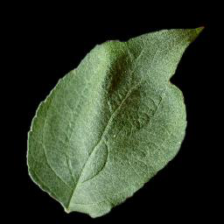

In [25]:
query_features = extract_features(QUERY_PATH, model)
print(query_features)

query_image_pil = tf.keras.utils.load_img(QUERY_PATH, target_size=(224,224), interpolation='bilinear')
query_image_pil

In [30]:
k = 10
query_object = Object(query_features, query_index)
kNN, dNN, distance_computations, time = vp_tree_index.search_kNN(query_object,k)

for i in range(k):
  print(kNN[i].id)
  print(dNN[i])


print(f"Ho computato {distance_computations} su {vp_tree_index.size} oggetti nell'indice")

1801
0.0
2584
0.0
33846
19.615725
1225
20.803995
4106
20.803995
38742
20.804163
40283
20.804163
33930
21.246593
62883
21.364882
20999
21.455122
Ho computato 45762 su 97034 oggetti nell'indice


In [29]:
import time
features_query = extract_features
query = Object(features[0], "Query")

kNN, dNN, distance_computations, time_kNN = vp_tree_index.search_kNN(query,10)

print(f"Tempo impiegato {time_kNN}")

k=10

for i in range(k):
  print(kNN[i].id)
  print(dNN[i])

print(f"Ho computato {distance_computations} su {vp_tree_index.size} oggetti nell'indice")

Tempo impiegato 2.0149075984954834
0
0.0
16554
36.278023
16593
36.278023
45663
37.647655
45685
38.090603
67643
38.18627
35125
38.616344
43990
38.666718
45861
38.666718
16873
39.064995
Ho computato 67261 su 97034 oggetti nell'indice


In [33]:
paths = dataframe['Path'].to_numpy()
labels = dataframe['Plant']

kNN_paths = [paths[int(obj.id)] for obj in kNN]
kNN_labels = [labels[int(obj.id)] for obj in kNN]

show_results(kNN_paths, dNN, kNN_labels)

In [31]:
def show_results(image_paths, scores, captions=None):
  """
  Shows results of a similarity search. Lists of image paths, scores, and
  (optionally) captions must be of the same length and follow the same order.
  
  Args:
    image_paths (ndarray or list): ordererd paths of images to be shown.
    scores (ndarray or list): ordered scores values to be shown next to images.
    captions (ndarray or list): ordered strings of captions to be shown; if
                                None, no caption is shown. Defaults to None.
  
  """
  if captions is None:
    captions = [''] * len(scores)  # just all empty strings

  for image_path, score, caption in zip(image_paths, scores, captions):
    title = 'score: {:.6f}'.format(score)
    display_image(image_path, title, caption)

In [32]:
def display_image(image_path, title='', txt=''):
  """ Displays an image with optional title and text next to it using iPython
  widgets (works in Jupyter/Colab environments).
      
  Args:
    image_path (string): path to the image to show.
    title (string): header text to show next to the image.
    txt (string): text to show under the title header.
  """
  image_widget = Image.from_file(image_path, width=200, height=100)
  txt = txt.replace('\n', '<br>')
  text_widget = HTML('<p><b>{}</b></p><p>{}</p>'.format(title, txt))
  widget = HBox([image_widget, text_widget])
  display(widget)